# Сравнение распределений в эксперименте и моделировании

## Коррекция по полярному углу в дрейфовой камере

Для этого сравниваю распределения по полярному углу для пионов в распаде каонов из $e^+ e^- \to K_S K_L$ для эксперимента и моделирования. 
Беру события, где один из пионов летит ортогонально камере, т.к. такие события хорошо моделируются.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import uproot
import numpy as np

import matplotlib.pyplot as plt
from pylib.style import my_style, hep_histo
from pylib.statistics import chi2_ndf
%matplotlib inline
PI = np.pi
plt.rcParams['figure.dpi'] = 120

In [42]:
def momentum_mass_cut(ksptot, ksminv, emeas, cut=10):
    mKs = 497.6
    x = emeas*2e-3;
    phi =  0.205/(x-0.732) + 0.14;
    p0 = np.sqrt(emeas**2 - mKs**2);
    return np.abs( (ksminv - mKs)*np.cos(phi) - (ksptot - p0)*np.sin(phi) ) < cut;

def prepare_data(file):
    df = uproot.open(file)['t'].pandas.df()
    df = df[momentum_mass_cut(df.ksptot, df.ksminv, df.emeas, 5)]
    return df.query('abs(ksminv-497.6)<15.&ksalign>0.95&(ebeam<5e3)')

def extract_polar(df):
    df = df.reset_index()
    cutAngle = 0.2
    dfAngles = pd.DataFrame(columns=['ebeam', 'ortoAngle', 'longAngle'])
    for i in range(2):
        q = df.query(f'abs(`tth[{i}]`-@PI/2)<@cutAngle')
        dfAngles = dfAngles.append(q[['ebeam', f'tth[{i}]', f'tth[{1-i}]']].rename({
            f'tth[{i}]': 'ortoAngle', f'tth[{1-i}]': 'longAngle'
        }, axis='columns'))
    return dfAngles

def get_size(df):
    return df.groupby('ebeam').agg('size')

def assign_mc_weight(*dfMCs):
    dic = {}
    for i, dfMC in enumerate(dfMCs):
        dic[i] = get_size(dfMC)
    dfSizes = pd.DataFrame(dic).dropna()
    dfRet = []
    for col, df in zip(dfSizes.columns, dfMCs):
        weight = dfSizes[0]/dfSizes[col]
        df = df.set_index('ebeam').loc[dfSizes.index]
        dfRet.append( df.join(pd.DataFrame({'weight': weight})) )
    return dfRet

In [43]:
dfExp, dfMC = prepare_data('../trees/exp2019_allTheta_allMoms.root'), prepare_data('../trees/mc19_sg.root')

In [44]:
dfExp, dfMC = assign_mc_weight(dfExp, dfMC)

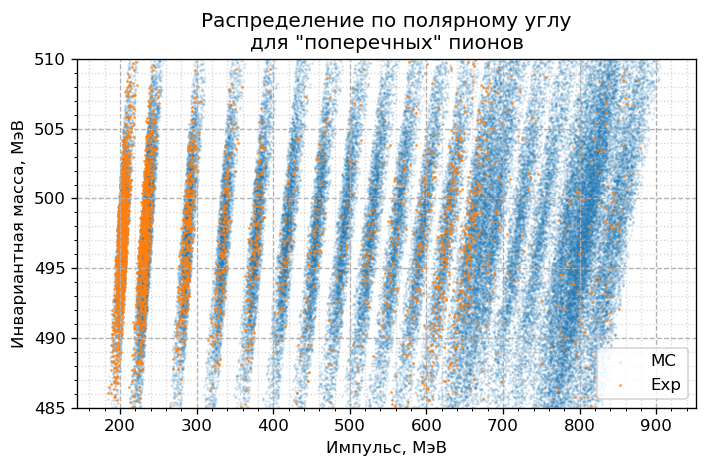

In [45]:
plt.scatter( dfMC['ksptot'],  dfMC['ksminv'], marker='.',  label='MC', s=1, alpha=0.2);
plt.scatter(dfExp['ksptot'], dfExp['ksminv'], marker='.', label='Exp', s=1);
plt.ylim(485, 510);
my_style('Распределение по полярному углу\nдля "поперечных" пионов', 'Импульс, МэВ', 'Инвариантная масса, МэВ', legend=True)

In [46]:
dfExp.head()

,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],trho[1],...,tchi2r[1],tchi2z[0],tchi2z[1],tnhit[0],tnhit[1],ksminv,ksptot,ksalign,kslen,weight
ebeam,,,,,,,,,,,,,,,,,,,,,
537.5,537.454102,3,1.425534,2.139219,-0.976147,-1.563741,304.971161,143.951935,-0.267683,0.735049,...,0.522352,0.647258,2.100581,17,16,496.262360,203.401581,0.999431,1.175832,1.0
537.5,537.454102,3,1.455213,2.234391,0.317866,-0.030805,258.594757,198.424026,-0.595437,0.920074,...,1.345532,0.755782,0.695421,14,15,496.554230,206.126572,0.998894,1.025642,1.0
537.5,537.454102,3,1.894865,1.394899,-0.909277,-0.699706,153.818985,293.625671,0.840106,-0.396094,...,1.031189,0.731442,0.980314,20,20,493.943909,200.902481,0.999289,0.923352,1.0
537.5,537.454102,3,2.126732,1.562193,0.804099,0.943203,199.503021,252.910767,0.196475,-0.125855,...,0.268280,0.940191,1.407143,16,15,494.936981,196.328110,0.998888,0.233728,1.0
537.5,537.454102,3,1.666386,1.924007,2.637726,3.666315,188.319763,270.338135,-0.275762,0.167117,...,0.795585,1.833715,0.898575,17,17,496.669403,201.471436,0.977044,0.334053,1.0


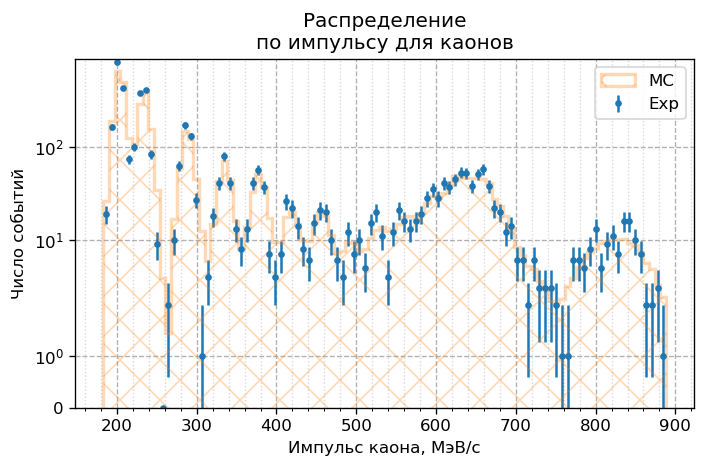

In [47]:
bins = 100
range1 = (dfExp.ksptot.min(), dfExp.ksptot.max())
hep_histo(dfExp.ksptot, bins=bins, label='Exp', range=range1);
plt.hist(  dfMC.ksptot, bins=bins, histtype='step', lw=2, label='MC',  weights=dfMC.weight, hatch='/\\', alpha=0.3, range=range1);
my_style('Распределение\nпо импульсу для каонов', 'Импульс каона, МэВ/с', 'Число событий', legend=True);
plt.yscale('symlog');

In [48]:
chi2, ndf = chi2_ndf(dfExp.ksptot, dfMC.ksptot, range=(100, 920), bins=250, weights2=dfMC.weight)
print(f'Хи-квадрат/ndf: {chi2:.2f}/{ndf}')

Хи-квадрат/ndf: 719.31/203


In [49]:
len(dfExp), dfMC.weight.sum()

(4335, 4334.999999999999)

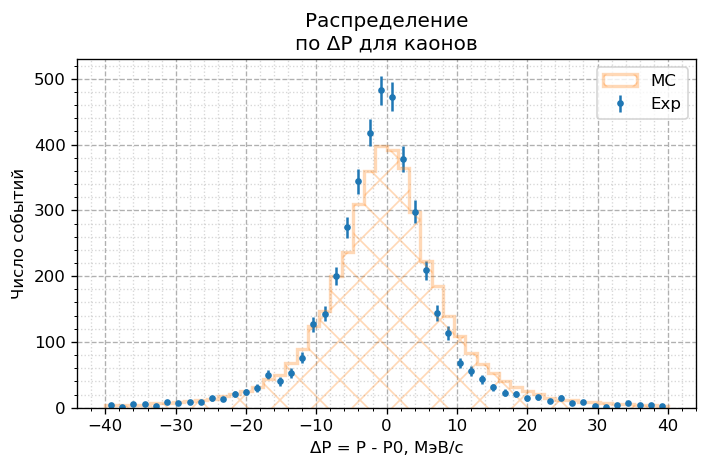

In [50]:
bins = 50
range1 = (-40, 40)
hep_histo(dfExp.ksptot - np.sqrt(dfExp.emeas**2 - 497.6**2), bins=bins, label='Exp', range=range1)
plt.hist(  dfMC.ksptot - np.sqrt(dfMC.emeas**2 - 497.6**2), bins=bins, histtype='step', lw=2, label='MC', 
         weights=dfMC.weight, hatch='/\\', alpha=0.3, range=range1)
my_style('Распределение\nпо ΔP для каонов', 'ΔP = P - P0, МэВ/с', 'Число событий', legend=True);
# plt.yscale('log');

In [51]:
chi2, ndf = chi2_ndf(dfExp.ksminv - np.sqrt(dfExp.emeas**2 - 497.6**2), 
                      dfMC.ksminv - np.sqrt( dfMC.emeas**2 - 497.6**2), range=(-40, 40), bins=50, weights2=dfMC.weight)
print(f'Хи-квадрат/ndf: {chi2:.2f}/{ndf}')

Хи-квадрат/ndf: 28.67/34


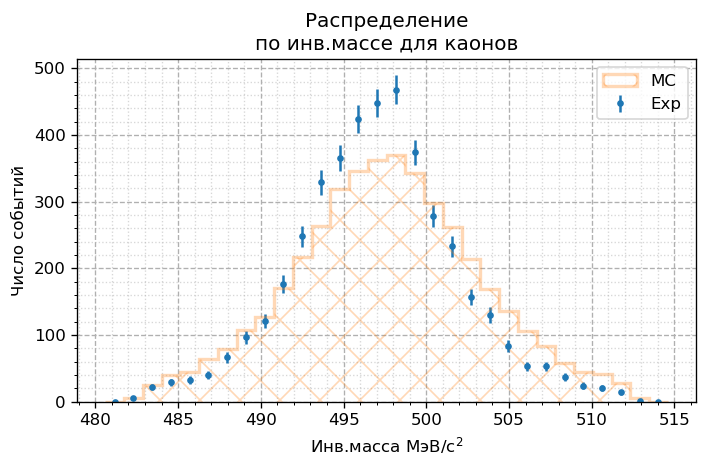

In [52]:
bins = 30
range1 = (497.6-17, 497.6+17)
hep_histo(dfExp.ksminv, bins=bins, label='Exp', range=range1);
plt.hist(  dfMC.ksminv, bins=bins, histtype='step', lw=2, label='MC',  weights=dfMC.weight, range=range1, alpha=0.3, hatch='\\/');
my_style('Распределение\nпо инв.массе для каонов', 'Инв.масса МэВ/c${}^2$', 'Число событий', legend=True)

In [53]:
chi2, ndf = chi2_ndf(dfExp.ksminv, dfMC.ksminv, range=(485, 510), bins=30, weights2=dfMC.weight)
print(f'Хи-квадрат/ndf: {chi2:.2f}/{ndf}')

Хи-квадрат/ndf: 273.89/29


In [54]:
dfExpAngles = extract_polar(dfExp)
dfMCAngles  = extract_polar(dfMC)

In [55]:
dfExpAngles, dfMCAngles = assign_mc_weight(dfExpAngles, dfMCAngles)

## Гистограммы

Строю гистограммы по полярному углу ортогонально камере и сравниваю с моделированием

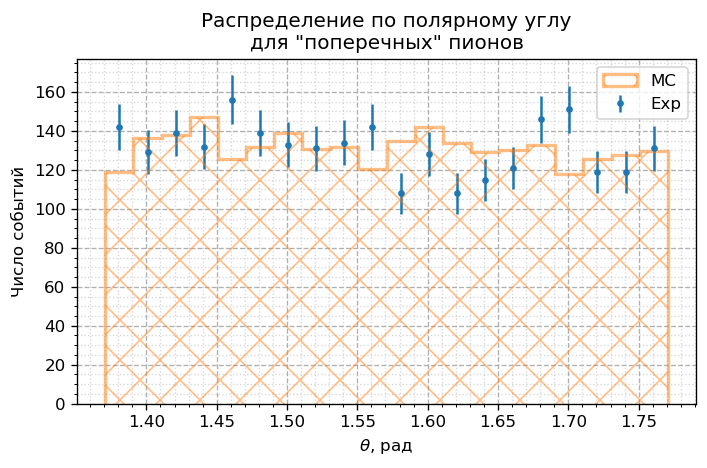

In [57]:
bins = 20
hep_histo(dfExpAngles.ortoAngle, bins=bins, label='Exp');
plt.hist(  dfMCAngles.ortoAngle, bins=bins, histtype='step', lw=2, label='MC',  weights=dfMCAngles.weight, alpha=0.5, hatch='\\/');
my_style('Распределение по полярному углу\nдля "поперечных" пионов', '$\\theta$, рад', 'Число событий', legend=True)

Здесь гистограмма с моделированием нормирована на количество эксперимента в этой гистограмме

Проверю по $\chi^2$ согласуется ли эксперимент с моделированием

In [55]:
chi2, ndf = chi2_ndf(dfExpAngles.ortoAngle, dfMCAngles.ortoAngle, range=(0, PI), bins=140, weights2=dfMCAngles.weight)
print(f'Хи-квадрат/ndf: {chi2:.2f}/{ndf}')

Хи-квадрат/ndf: 38.69/17


Теперь сравниваю полярные углы "продольных" пионов

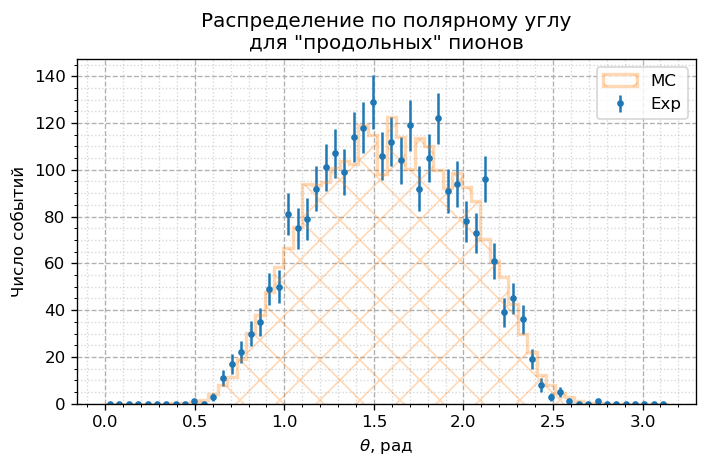

In [58]:
bins = 60
hep_histo(dfExpAngles.longAngle, bins=bins, label='Exp', range=(0, PI));
plt.hist(  dfMCAngles.longAngle, bins=bins, histtype='step', lw=2, label='MC', 
         weights=dfMCAngles.weight, range=(0, PI), alpha=0.3, hatch='\\/');
my_style('Распределение по полярному углу\nдля "продольных" пионов', '$\\theta$, рад', 'Число событий', legend=True)

In [57]:
chi2, ndf = chi2_ndf(dfExpAngles.longAngle, dfMCAngles.longAngle, range=(0, PI), bins=160, weights2=dfMCAngles.weight)
print(f'Хи-квадрат/ndf: {chi2:.2f}/{ndf}')

Хи-квадрат/ndf: 190.19/103


Построю гистограмму с разницей между моделированием и экспериментом

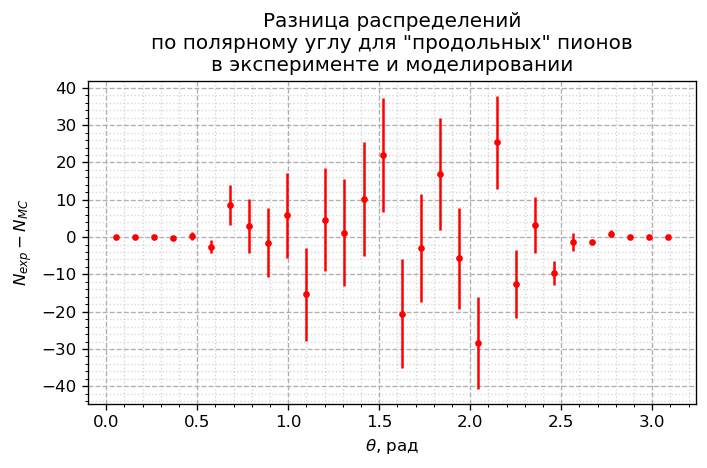

In [59]:
bins = 30
dataExp, binsExp = np.histogram(dfExpAngles.longAngle, bins=bins, range=(0, PI))
dataMC,  binsMC  = np.histogram( dfMCAngles.longAngle, bins=bins, range=(0, PI), weights=dfMCAngles.weight)
plt.errorbar((binsExp[1:]+binsExp[:-1])/2, dataExp - dataMC, 
             yerr=np.sqrt(dataExp), fmt='r.')
my_style('Разница распределений\nпо полярному углу для "продольных" пионов\nв эксперименте и моделировании', 
         '$\\theta$, рад', '$N_{exp} - N_{MC}$', legend=False)

In [60]:
dfBins = pd.DataFrame({'bin': (binsExp[1:]+binsExp[:-1])/2, 'exp': dataExp, 'mc': dataMC})
dfBins['div'] = dfBins.exp/dfBins.mc
dfBins['err'] = np.sqrt(dfBins.exp)/dfBins.mc
dfBins.replace([np.inf, -np.inf, 0], np.nan, inplace=True)
dfBins.dropna(inplace=True)

In [61]:
from iminuit import Minuit

def chi2(mean):
    return np.sum(((dfBins['div'] - mean)/dfBins['err'])**2)

m = Minuit(chi2, pedantic=False)
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 33.77                      │        Ncalls = 13 (13 total)        │
│ EDM = 1.34e-16 (Goal: 0.0002)    │               up = 1.0               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean │   0.988   │   0.019   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

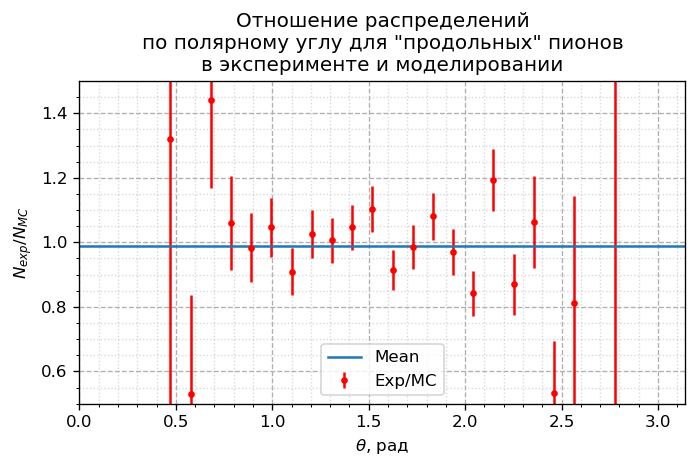

In [62]:
plt.errorbar(dfBins.bin, dfBins['div'], yerr=dfBins.err,  fmt='r.', label='Exp/MC')
plt.plot([0, PI], m.values['mean']*np.ones(2), label='Mean')
my_style('Отношение распределений\nпо полярному углу для "продольных" пионов\nв эксперименте и моделировании', 
         '$\\theta$, рад', '$N_{exp}/N_{MC}$', legend=True)
plt.ylim(0.5, 1.5)
plt.xlim(0, PI);

In [63]:
dfBins.head()

,bin,exp,mc,div,err
4,0.471239,1.0,0.757652,1.319867,1.319867
5,0.575959,3.0,5.646651,0.531288,0.306739
6,0.680678,28.0,19.413371,1.442305,0.272570
7,0.785398,52.0,49.053965,1.060057,0.147003
8,0.890118,84.0,85.460460,0.982911,0.107244


## Задачи/Вопросы

1. Проверить `elabel`
1. Проверить другие сезоны (2011, 2012)
1. Попробовать начать с макушки $\phi$-мезона
1. Проверить, как сравниваются распределения
1. $P$ и $M$ от длины распада/отлёта  $K_S$

## Проверяю `elabel`

На примере 19 года соотнесу три/четыре типа моделирования: **MCGPJ** и **cmd2_gen** с `elabel` и без

In [66]:
dfExp = prepare_data('../trees/exp2019_allTheta_allMoms.root')
dfMC_19sg, dfMC_7pj, dfMC_7sg = prepare_data('../trees/mc19_sg.root'), prepare_data('../trees/mc7_mcgpj.root'), prepare_data('../trees/mc7_sg.root')
dfExp, dfMC_19sg, dfMC_7pj, dfMC_7sg = assign_mc_weight(dfExp, dfMC_19sg, dfMC_7pj, dfMC_7sg)

In [5]:
dfMC_19sg.head()

,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],trho[1],...,tchi2r[1],tchi2z[0],tchi2z[1],tnhit[0],tnhit[1],ksminv,ksptot,ksalign,kslen,weight
ebeam,,,,,,,,,,,,,,,,,,,,,
537.5,537.5,3,1.472715,1.349154,0.936732,0.713816,190.051743,265.646393,1.838881,-1.363237,...,0.384487,0.830788,1.726275,18,15,496.486786,204.792557,0.999991,1.990326,0.447801
537.5,537.5,1,2.149166,0.951403,2.831232,1.674136,287.277100,169.116745,0.737028,-1.252668,...,0.797605,0.799701,0.833806,15,15,497.090820,200.326782,0.999917,1.318030,0.447801
537.5,537.5,3,1.785568,2.104009,-0.234578,-0.341567,188.895462,264.376221,0.273394,-0.190405,...,0.467781,1.128514,1.224793,15,18,495.475830,200.005615,0.984609,0.609774,0.447801
537.5,537.5,3,1.234896,1.392314,3.799746,4.879348,280.996643,174.841019,-0.293823,0.493815,...,1.993137,1.334826,0.831324,17,17,496.674316,201.801773,0.995326,0.651483,0.447801
537.5,537.5,3,1.653791,1.588032,0.781196,0.500936,140.299942,293.247162,0.723954,-0.328564,...,0.330100,0.540207,0.649325,19,17,484.920135,195.094269,0.999712,0.873938,0.447801


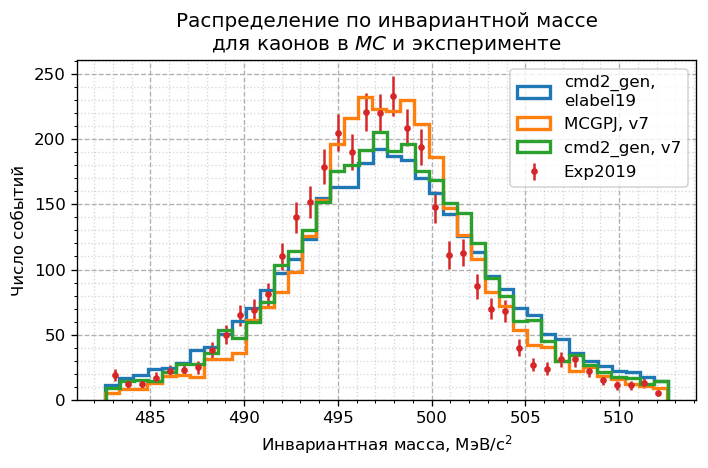

In [70]:
bins = 40
plt.hist(dfMC_19sg.ksminv, bins=bins, histtype='step', lw=2, label='cmd2_gen,\nelabel19',  weights=dfMC_19sg.weight);
plt.hist( dfMC_7pj.ksminv, bins=bins, histtype='step', lw=2, label='MCGPJ, v7',  weights=dfMC_7pj.weight);
plt.hist( dfMC_7sg.ksminv, bins=bins, histtype='step', lw=2, label='cmd2_gen, v7',  weights=dfMC_7sg.weight);
hep_histo(dfExp.ksminv, bins=bins, label='Exp2019')
my_style('Распределение по инвариантной массе\nдля каонов в $MC$ и эксперименте', 'Инвариантная масса, МэВ/с${}^2$', 'Число событий', legend=True)

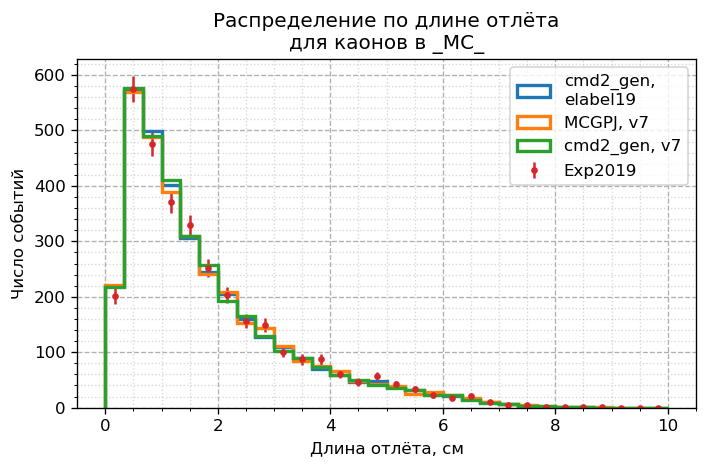

In [39]:
bins = 30
range1 = (0, 10)
plt.hist(dfMC_19sg.kslen, bins=bins, histtype='step', lw=2, label='cmd2_gen,\nelabel19',  weights=dfMC_19sg.weight, range=range1);
plt.hist( dfMC_7pj.kslen, bins=bins, histtype='step', lw=2, label='MCGPJ, v7',  weights=dfMC_7pj.weight, range=range1);
plt.hist( dfMC_7sg.kslen, bins=bins, histtype='step', lw=2, label='cmd2_gen, v7',  weights=dfMC_7sg.weight, range=range1);
hep_histo(dfExp.kslen, bins=bins, label='Exp2019', range=range1)
# plt.yscale('log')
my_style('Распределение по длине отлёта\nдля каонов в _MC_', 'Длина отлёта, см', 'Число событий', legend=True)

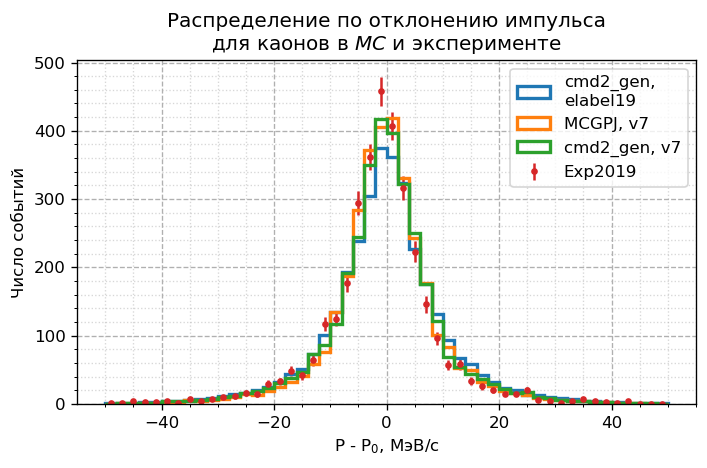

In [67]:
bins = 50
range1 = (-50, 50)
p0 = lambda x: np.sqrt(x.emeas**2 - 497.6**2)
plt.hist(dfMC_19sg.ksptot - p0(dfMC_19sg), bins=bins, histtype='step', lw=2, label='cmd2_gen,\nelabel19',  weights=dfMC_19sg.weight, range=range1);
plt.hist( dfMC_7pj.ksptot -  p0(dfMC_7pj), bins=bins, histtype='step', lw=2, label='MCGPJ, v7',  weights=dfMC_7pj.weight, range=range1);
plt.hist( dfMC_7sg.ksptot -  p0(dfMC_7sg), bins=bins, histtype='step', lw=2, label='cmd2_gen, v7',  weights=dfMC_7sg.weight, range=range1);
hep_histo(dfExp.ksptot - p0(dfExp), bins=bins, label='Exp2019', range=range1)
# plt.yscale('log')
my_style('Распределение по отклонению импульса\nдля каонов в $MC$ и эксперименте', 'P - P$_0$, МэВ/с', 'Число событий', gridstyle='--', legend=True)

В результате видно, что `elabel` меняет распределение в моделировании, значит, работает, однако распределения с `elabel` мало согласуются с экспериментальными, хотя здесь может быть делов генераторе **cmd2_gen**

## Проверить процедуру сравнения

Для этого генерирую несколько гауссовых распределений с разными весами и сравниваю их согласно своей процедуре

In [90]:
from numpy.random import default_rng
from random import randint

g = default_rng(55)
def foo(i, size=1000):
    df = pd.DataFrame({'ksminv': g.normal(size=size, loc=497.6, scale=i+1)})
    df['ebeam'] = i
    return df
dfE = pd.concat([foo(i, randint(100, 30000)) for i in range(10)])
dfMC = pd.concat([foo(i, randint(100, 30000)) for i in range(2, 11)])

In [91]:
dfE, dfMC = assign_mc_weight(dfE, dfMC)

In [95]:
dfMC.head()

,ksminv,weight
ebeam,,
2,491.994720,1.919057
2,494.159911,1.919057
2,493.877596,1.919057
2,499.801635,1.919057
2,498.451990,1.919057


Chi2/ndf (276.73090741113384, 119)


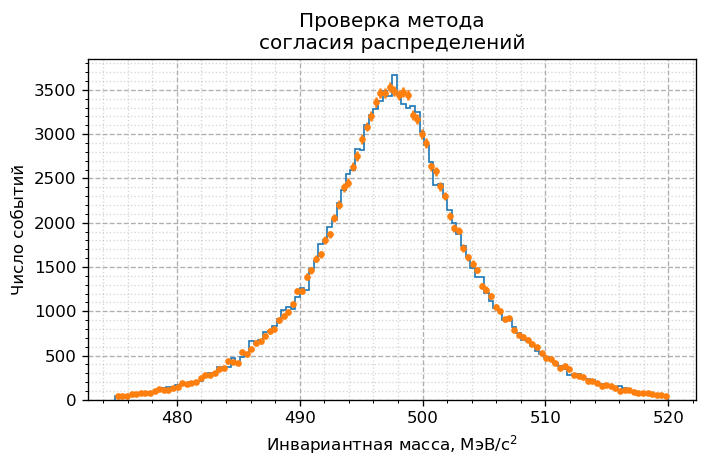

In [123]:
bins = 120
r0 = (475, 520)
plt.hist(dfMC.ksminv, bins=bins, range=r0, histtype='step', weights=dfMC.weight);
hep_histo(dfE.ksminv, bins=bins, range=r0)
my_style('Проверка метода\nсогласия распределений', 'Инвариантная масса, МэВ/c$^2$', 'Число событий')
print('Chi2/ndf', chi2_ndf(dfE.ksminv, dfMC.ksminv, range=r0, bins=bins, weights1=dfE.weight, weights2=dfMC.weight))